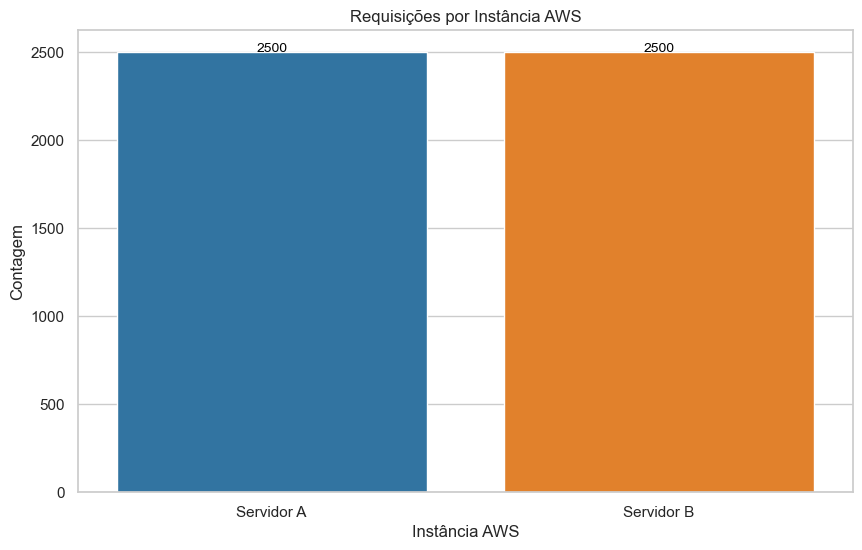

C:\Users\petro\AppData\Local\Temp\ipykernel_21388\3755915147.py:37: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=df, x='timestamp', y='aws_instance_id', palette='tab10')


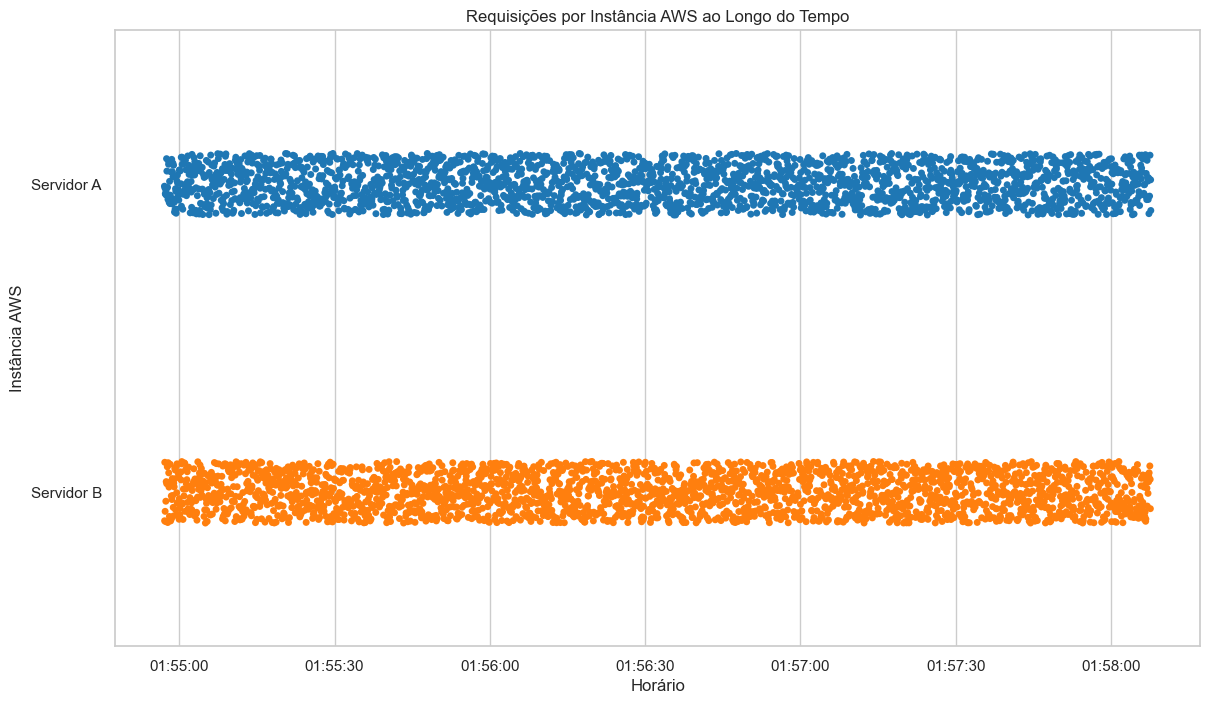

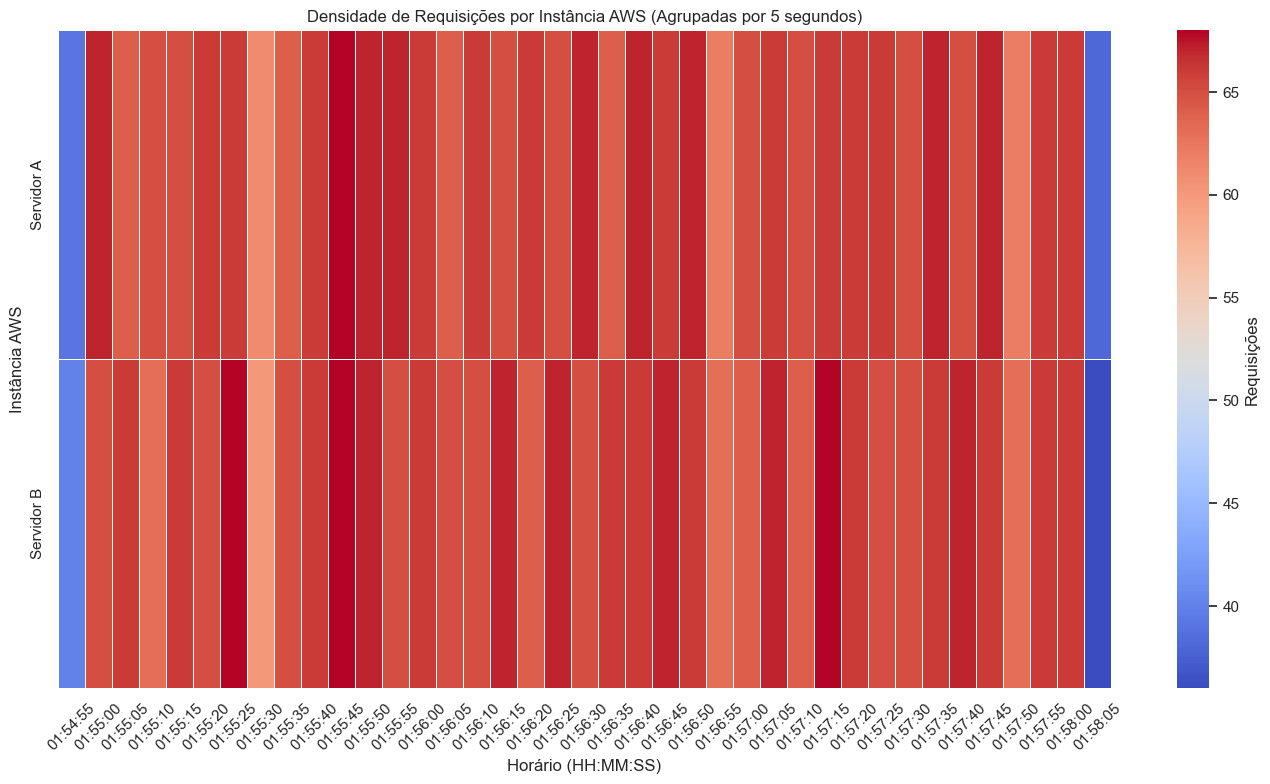

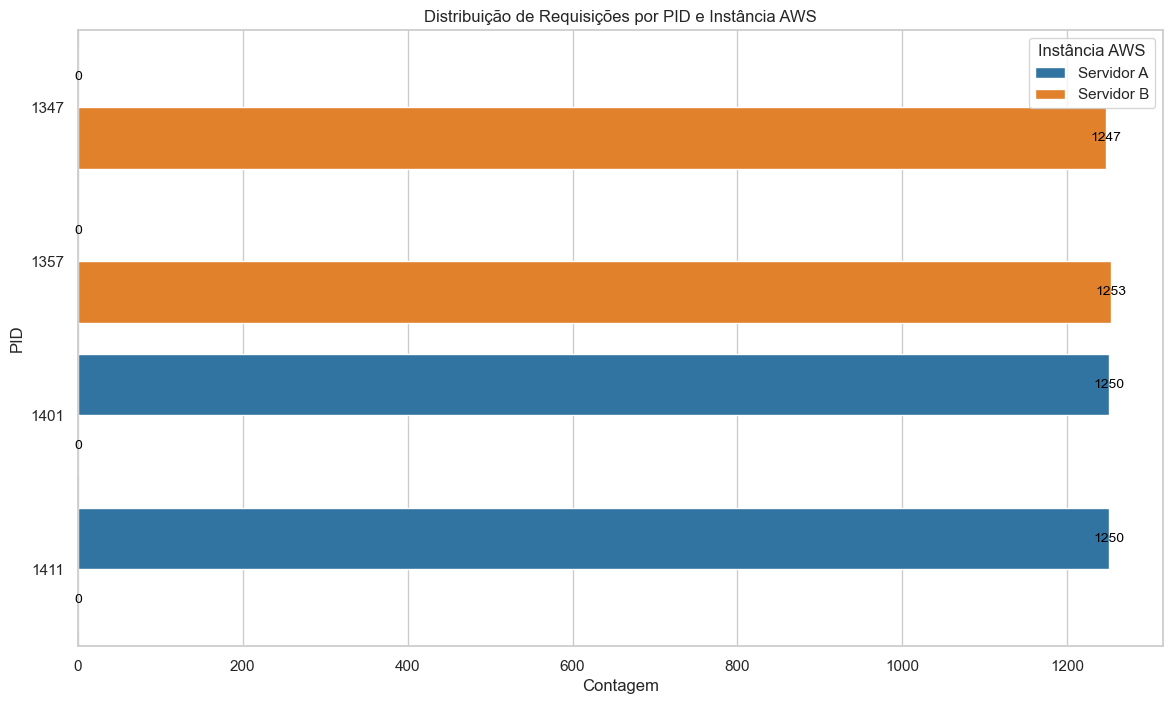

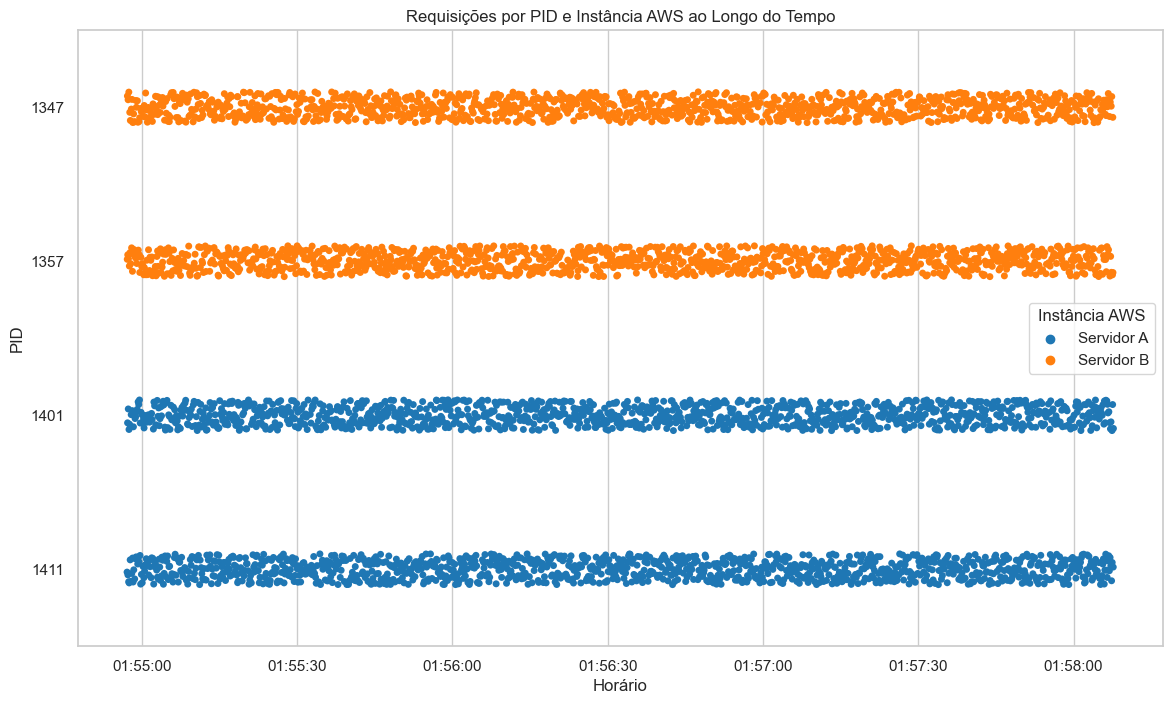

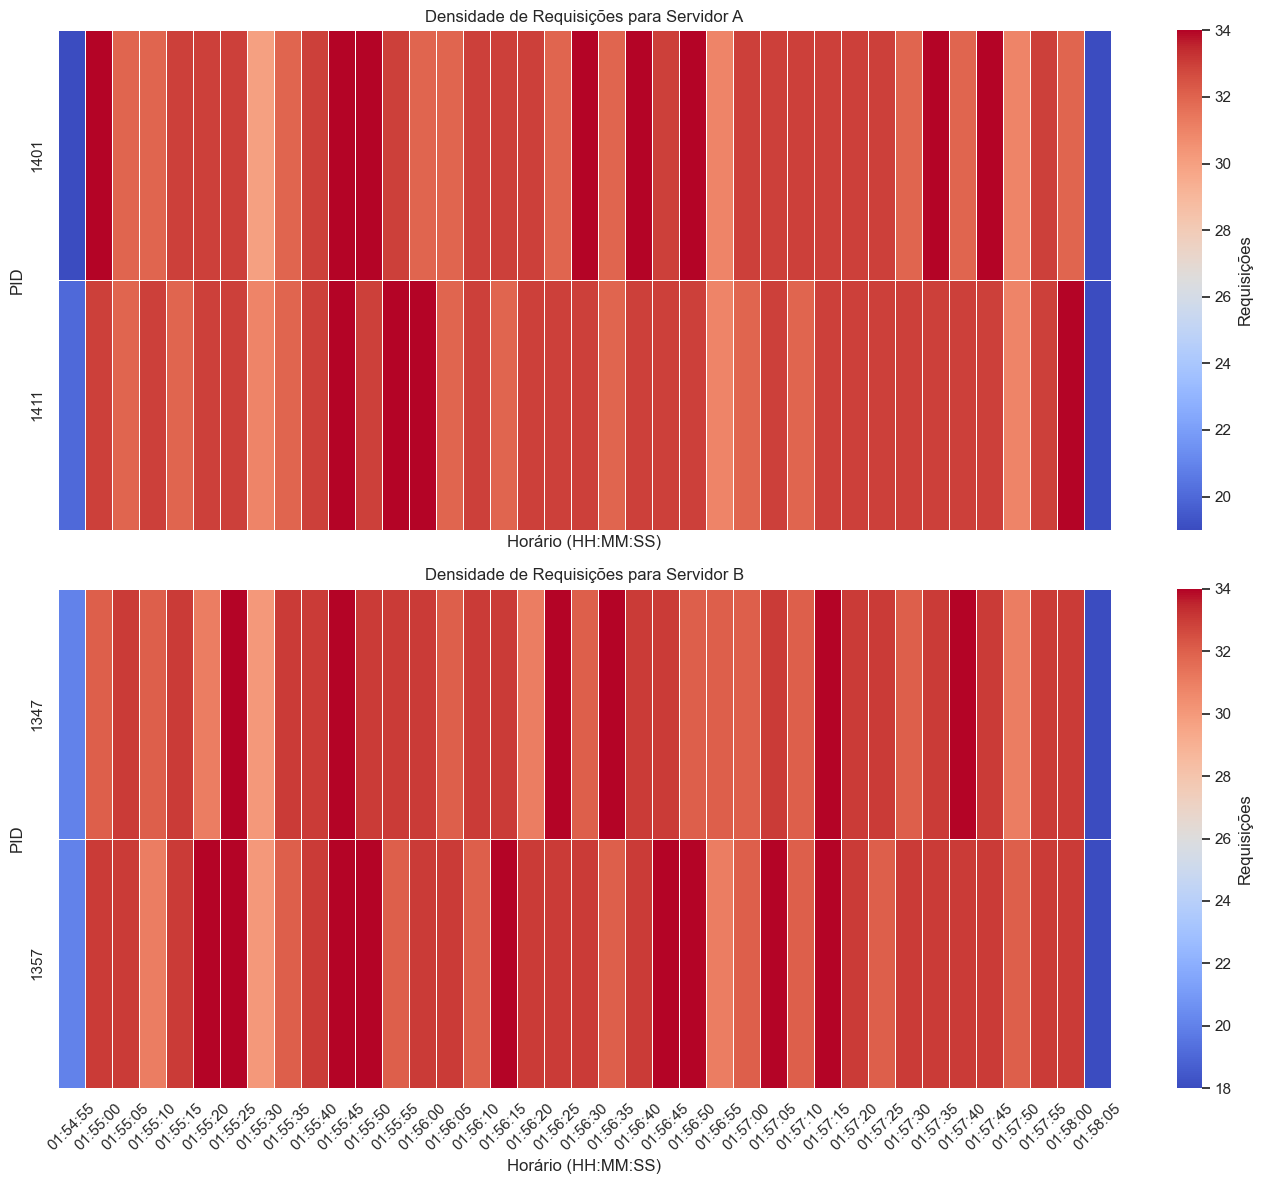

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações do seaborn
sns.set(style="whitegrid")

# Carregar os dados do arquivo CSV
def load_data(file_path):
    return pd.read_csv(file_path)

# Converter timestamp para datetime
def preprocess_data(df):
    df['pid'] = df['pid'].astype('category')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # parse i-016c893ecfaecb2c8 -> Servidor 1
    # parse i-0e3a8aa1e289f40cf -> Servidor 2
    df['aws_instance_id'] = df['aws_instance_id'].apply(lambda x: 'Servidor A' if x == 'i-016c893ecfaecb2c8' else 'Servidor B')
    return df

# Criar gráficos
def create_graphs(df):
    
    # Contagem de requisições por instância AWS
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='aws_instance_id', data=df, palette='tab10')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() + 1),
                    ha='center', va='baseline', fontsize=10, color='black')
    plt.title('Requisições por Instância AWS')
    plt.xlabel('Instância AWS')
    plt.ylabel('Contagem')
    plt.show()
    
    # Dot plot de requisições over time (timestamp) por instância AWS
    plt.figure(figsize=(14, 8))
    ax = sns.stripplot(data=df, x='timestamp', y='aws_instance_id', palette='tab10')
    plt.title('Requisições por Instância AWS ao Longo do Tempo')
    plt.xlabel('Horário')
    plt.ylabel('Instância AWS')
    plt.show()
    
    # Heatmap plot de densidade de requisições por instância AWS
    df['time_bin'] = df['timestamp'].dt.floor('5S')  # Agrupar por 5 segundos
    df['formatted_time'] = df['time_bin'].dt.strftime('%H:%M:%S')  # Exibir apenas horário
    density = df.groupby(['formatted_time', 'aws_instance_id']).size().unstack(fill_value=0)
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        density.T,  # Transpor para colocar as instâncias no eixo y
        cmap='coolwarm',  # Escolha uma paleta
        cbar_kws={'label': 'Requisições'},
        linewidths=0.5
    )
    plt.title('Densidade de Requisições por Instância AWS (Agrupadas por 5 segundos)')
    plt.xlabel('Horário (HH:MM:SS)')
    plt.ylabel('Instância AWS')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Requisições por PID e instância AWS
    plt.figure(figsize=(14, 8))
    ax = sns.countplot(data=df, y='pid', hue='aws_instance_id', palette='tab10')
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 0.2, p.get_y() + p.get_height() / 2., f'{int(width)}',
                 ha='center', va='center', fontsize=10, color='black')
    plt.title('Distribuição de Requisições por PID e Instância AWS')
    plt.xlabel('Contagem')
    plt.ylabel('PID')
    plt.legend(title='Instância AWS')
    plt.show()
    
    # # Dot plot de Requisições por PID e instância AWS pelo tempo
    plt.figure(figsize=(14, 8))
    ax = sns.stripplot(data=df, x='timestamp', y='pid', hue='aws_instance_id', palette='tab10')
    plt.title('Requisições por PID e Instância AWS ao Longo do Tempo')
    plt.xlabel('Horário')
    plt.ylabel('PID')
    plt.legend(title='Instância AWS')
    plt.show()
    
    # Heatmap plot de densidade de requisições por PID e instância AWS
    unique_instances = df['aws_instance_id'].unique()
    n_instances = len(unique_instances)

    fig, axes = plt.subplots(
        nrows=n_instances, 
        figsize=(14, 6 * n_instances), 
        sharex=True
    )

    if n_instances == 1:
        axes = [axes]  # Garantir que axes seja iterável mesmo com uma única instância

    for ax, instance_id in zip(axes, unique_instances):
        # Filtrar para a instância atual
        filtered_df = df[df['aws_instance_id'] == instance_id]
        
        # Criar densidade por PID e time_bin
        density = filtered_df.groupby(['formatted_time', 'pid']).size().unstack(fill_value=0)
        
        # remover PID com 0 requisições
        density = density.loc[:, (density != 0).any(axis=0)]
        
        # Plotar heatmap para a instância
        sns.heatmap(
            density.T, 
            cmap='coolwarm',  # Escolha uma paleta
            cbar_kws={'label': 'Requisições'}, 
            linewidths=0.5, 
            ax=ax
        )
        ax.set_title(f'Densidade de Requisições para {instance_id}')
        ax.set_xlabel('Horário (HH:MM:SS)')
        ax.set_ylabel('PID')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    


# Função principal
# Caminho para o arquivo CSV
file_path = 'lb-results-5000.csv'

# Carregar e processar os dados
df = load_data(file_path)
df = preprocess_data(df)

# Análise e gráficos
create_graphs(df)
